<div class="clearfix" style="padding: 10px; padding-left: 0px">
<img src="resources/img/softbutterfly-logo.png" class="pull-left" style="display: block; height: 40px; margin: 0;"><img src="resources/img/jupyter-logo.png" class="pull-right"  style="display: block; height: 20px; margin-top: 10px;">
</div>

<h1 style="text-align:center;">Predicción del Ciclo Solar<div class="divider"></div><small>El algoritmo McNish - Lincoln</small></h1>

<div style="text-align:center">
<b>Martín Josemaría Vuelta Rojas</b><br>
<code>martin.vuelta@softbutterfly.io</code><br/><br/>
<i>Universidad Nacional Mayor de San Marcos</i><br>
Facultad de Ciencias Físicas<br><br>
<i>SoftButterfly</i><br>
Cofundador y Líder del Área de Desarrollo
</div>

## 1 Ajustes gráficos

In [1]:
%matplotlib inline

In [2]:
# Ajustes generales para los gráficos
from distutils.spawn import find_executable

from matplotlib.font_manager import *
from matplotlib.collections import *
from matplotlib.patches import *
from matplotlib.pylab import *
from matplotlib import colors

import gc

ioff()

rc('lines', linewidth=1)
rc('font', family='serif')

if find_executable('latex'):
    rc('text', usetex=True)

font_title = FontProperties(size=20)
font_label = FontProperties(size=15)
font_ticks = FontProperties(size=12)
font_legend = FontProperties(size=12)

## 2 Procesamiento de datos

### 2.1 Registros _crudos_

Los datos de machas solares pueden obtenerse desde la página web de [SILSO](http://www.sidc.be/silso)

In [3]:
url = "http://www.sidc.be/silso/DATA/SN_d_tot_V2.0.txt"

In [4]:
from urllib import request

req = request.urlopen(url)

In [5]:
import re

pattern = re.compile(r' +')

raw_data = req.read().decode('utf-8').strip('\n')
raw_data = pattern.sub(' ', raw_data)
raw_data = raw_data.split('\n')[:-1]
raw_data = map(lambda l: l.split(' '), raw_data)
raw_data = list(raw_data)

### 2.2 Registros diarios

In [6]:
from pandas import Timestamp


def flag(t):
    return t == '*'


def pairing(x):
    fns = [Timestamp, float, float, flag]
    return list(zip(fns, ['-'.join(x[0:3])] + x[4:6] + [x[-1]]))


def parse(x):
    return list(map(lambda y: y[0](y[1]), pairing(x)))

In [7]:
daily = list(zip(*map(parse, raw_data)))

In [8]:
from collections import OrderedDict
from pandas import DataFrame
from numpy import nan

headers = ['Date', 'SN value', 'SN error', 'Flag']
daily = DataFrame(OrderedDict(zip(headers, daily))).replace(-1.0, nan)

In [9]:
daily = daily.set_index(["Date"], drop=True)

#### 2.2.1 Gráfico de registros diarios

Los gráficos diarios se realizan en periodos de 50 años empezando desde 1818, el primer año de los registros obtenidos desde [SILSO](http://www.sidc.be/silso)

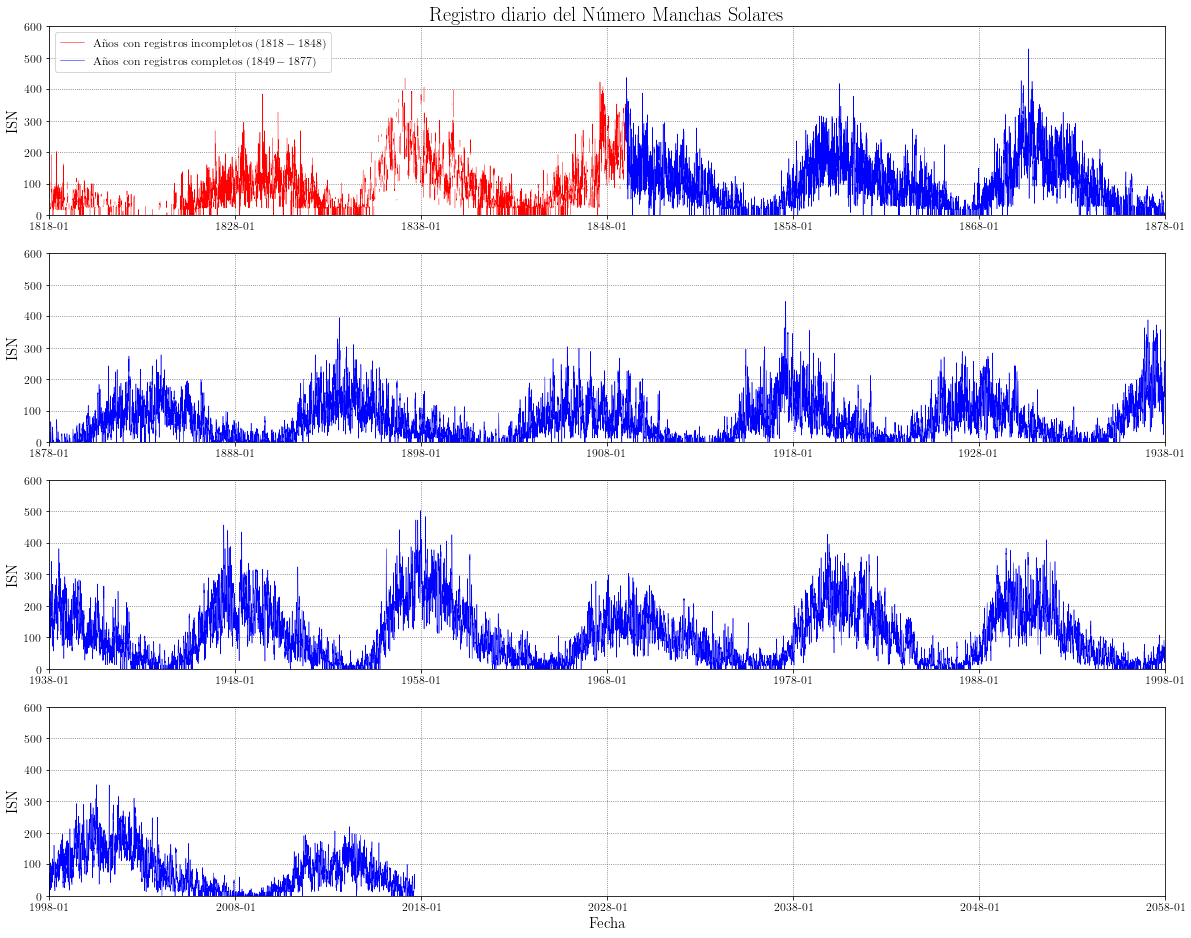

In [10]:
from pandas import Timedelta

yearDelta = 60
periods = (daily.index[-1].year - daily.index[0].year) / yearDelta
periods = ceil(periods)
periods = int(periods)

fig = figure(figsize=(20, periods * 4), frameon=False)

title = r"$\mathrm{Registro\ diario\ del\ N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = ceil(nanmax(daily['SN value']) / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot('{0:.0f}1{1:.0f}'.format(periods, i + 1))

    x_liml = Timestamp(daily.index[0].year + i * yearDelta, 1, 1)
    x_limu = Timestamp(daily.index[0].year + (i + 1) * yearDelta - 1, 12, 31)

    plotData = daily[x_liml:x_limu]

    if i == 0:
        nanStop = 0
        nanStop = where(isnan(plotData['SN value']))[0][-1] + 1
        nanStop = plotData.index[nanStop].year
        nanStop = Timestamp(nanStop, 12, 31)

        graph, = plot(
            plotData[:nanStop]['SN value'],
            color='red',
            linewidth=0.5,
            antialiased=True,
            label=(r"$\mathrm{A\tilde{n}os\ con\ }$" +
                   r"$\mathrm{registros\ incompletos\ }$" +
                   r"$({0:}-{1:})$".format(plotData.index[0].year,
                                           plotData[:nanStop].index[-1].year)))
        graph, = plot(
            plotData[nanStop:]['SN value'],
            color='blue',
            linewidth=0.5,
            antialiased=True,
            label=(
                r"$\mathrm{A\tilde{n}os\ con\ }$" +
                r"$\mathrm{registros\ completos\ }$" + r"$({0:}-{1:})$".format(
                    plotData[nanStop:].index[0].year + 1,
                    plotData.index[-1].year)))

        axs.set_title(title, fontproperties=font_title)
        axs.legend(loc=2, prop=font_legend)
    else:
        plot(
            plotData['SN value'],
            color='blue',
            linewidth=0.5,
            antialiased=True)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(yearDelta / 10)
    d_xticks = ceil(
        (x_limu.year - (x_liml + Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [
        Timestamp(int(x_liml.year + i * d_xticks), 1, 1)
        for i in range(n_xticks + 1)
    ]
    l_xticks = [
        r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks
    ]

    axs.set_xlim([x_liml, x_limu + Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    axs.grid(color='#666666', linestyle='dotted')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)

show()

### 2.3 Promedios mensuales

In [28]:
from numpy import nanmean
from numpy import nanstd
from numpy import isfinite
from numpy import isnan
from numpy import mean
from numpy import sqrt


def agg_mean(x):
    if all(isnan(x)):
        return nan

    return nanmean(x)


def agg_std(x):
    if all(isnan(x)):
        return nan

    return nanstd(x)


def agg_quadsum(x):
    if all(isnan(x)):
        return nan

    return sqrt(sum(x[isfinite(x)]**2))


def agg_all(x):
    return all(x)

In [29]:
monthly = daily.groupby([lambda x: x.year, lambda x: x.month])
monthly = monthly.agg({
    'SN value': [agg_mean, agg_std],
    'SN error': agg_quadsum,
    'Flag': [agg_all]
})

# Flattening labels
monthly.columns = [
    'Monthly SN mean', 'Monthly SN std', 'Monthly SN erros', 'Flag'
]

# Flattening indexes
monthly.index = [Timestamp(y, m, 1) for y, m in monthly.index.values]

#### 2.3.1 Gráfico de promedios mensuales

##### Promedios mensuales

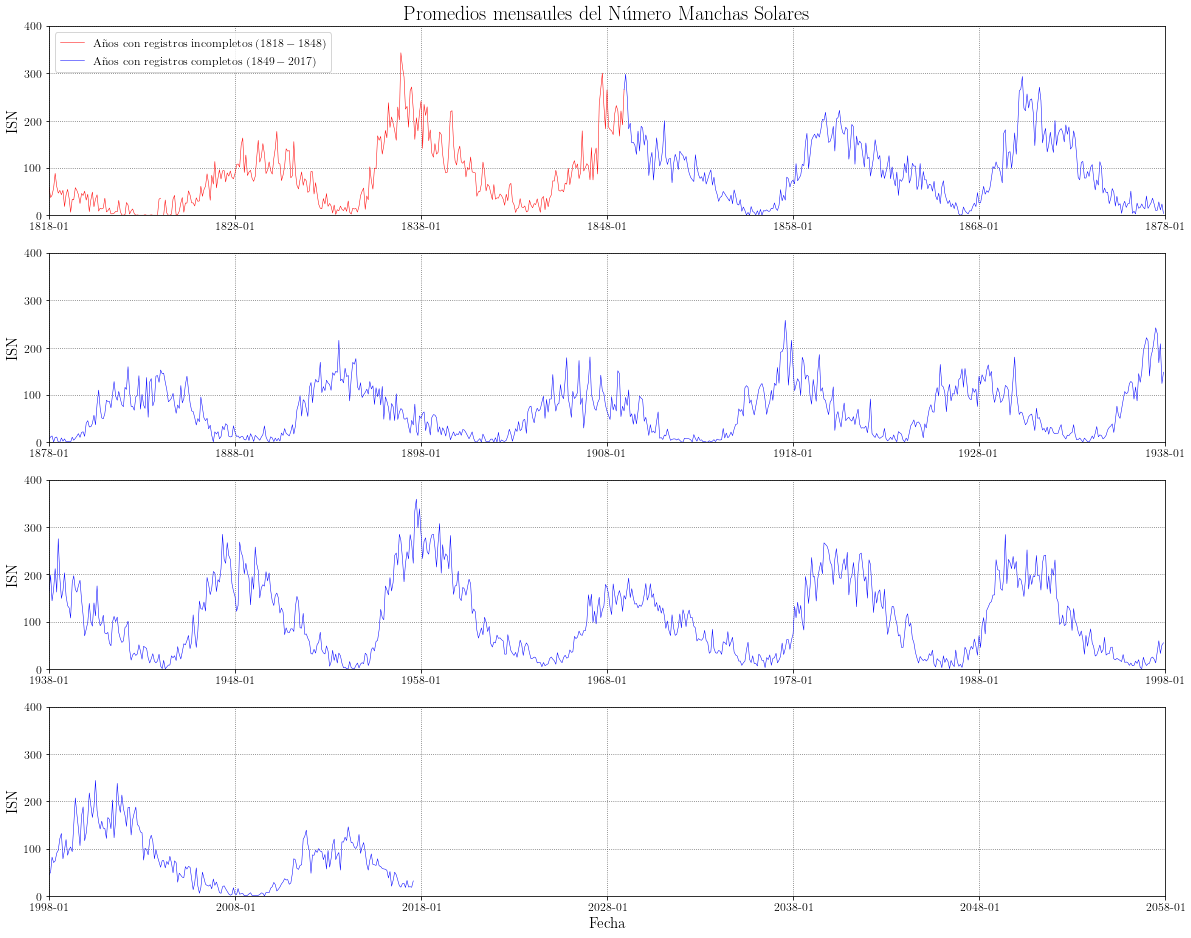

In [30]:
from pandas import Timedelta

yearDelta = 60
periods = (monthly.index[-1].year - monthly.index[0].year) / yearDelta
periods = ceil(periods)
periods = int(periods)

fig = figure(figsize=(20, periods * 4), frameon=False)

title = r"$\mathrm{Promedios\ mensaules\ del\ N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = ceil(nanmax(monthly['Monthly SN mean']) / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot('{0:.0f}1{1:.0f}'.format(periods, i + 1))

    x_liml = Timestamp(monthly.index[0].year + i * yearDelta, 1, 1)
    x_limu = Timestamp(monthly.index[0].year + (i + 1) * yearDelta - 1, 12, 31)

    plotData = monthly[x_liml:x_limu]

    if i == 0:
        nanStop = 0
        nanStop = where(isnan(daily['SN value']))[0][-1] + 1
        nanStop = daily.index[nanStop]
        nanStop = plotData[:nanStop].index[-1]
        
        graph, = plot(
            plotData['Monthly SN mean'][:nanStop],
            color='red',
            linewidth=0.5,
            antialiased=True,
            label=(r"$\mathrm{A\tilde{n}os\ con\ }$" +
                   r"$\mathrm{registros\ incompletos\ }$" +
                   r"$({0:}-{1:})$".format(plotData.index[0].year,
                                           plotData[:nanStop].index[-1].year)))
        
        graph, = plot(
            plotData['Monthly SN mean'][nanStop:],
            color='blue',
            linewidth=0.5,
            antialiased=True,
            label=(
                r"$\mathrm{A\tilde{n}os\ con\ }$" +
                r"$\mathrm{registros\ completos\ }$" + r"$({0:}-{1:})$".format(
                    plotData[nanStop:].index[0].year + 1,
                    daily.index[-1].year)))

        axs.set_title(title, fontproperties=font_title)
        axs.legend(loc=2, prop=font_legend)
    else:
        plot(
            plotData['Monthly SN mean'],
            color='blue',
            linewidth=0.5,
            antialiased=True)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(yearDelta / 10)
    d_xticks = ceil(
        (x_limu.year - (x_liml + Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [
        Timestamp(int(x_liml.year + i * d_xticks), 1, 1)
        for i in range(n_xticks + 1)
    ]
    l_xticks = [
        r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks
    ]

    axs.set_xlim([x_liml, x_limu + Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    axs.grid(color='#666666', linestyle='dotted')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)

show()

##### Superposición de promedios mensuales sobre los registros diarios

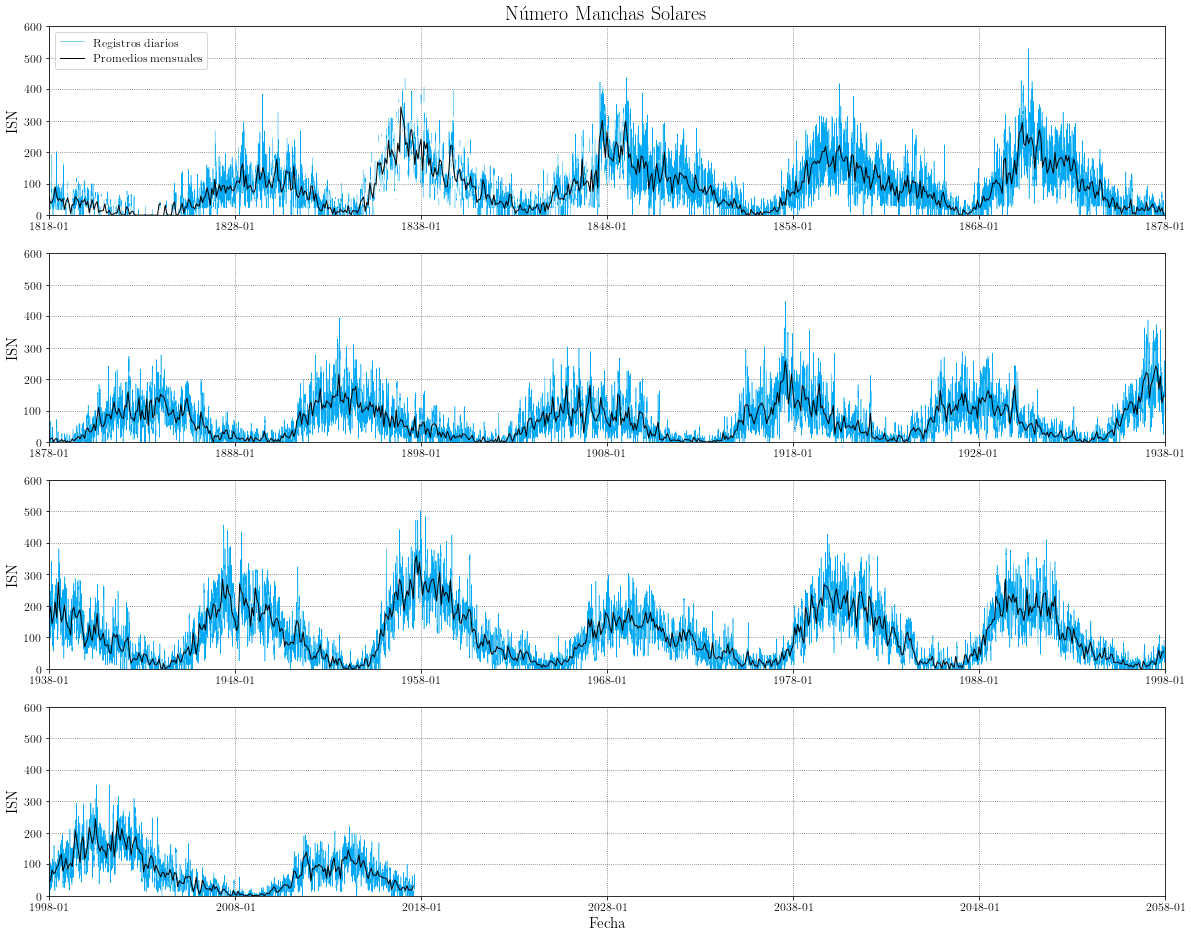

In [31]:
from pandas import Timedelta

yearDelta = 60
periods = (monthly.index[-1].year - monthly.index[0].year) / yearDelta
periods = ceil(periods)
periods = int(periods)

fig = figure(figsize=(20, periods * 4), frameon=False)

title = r"$\mathrm{N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = ceil(nanmax(daily['SN value']) / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot('{0:.0f}1{1:.0f}'.format(periods, i + 1))

    x_liml = Timestamp(daily.index[0].year + i * yearDelta, 1, 1)
    x_limu = Timestamp(daily.index[0].year + (i + 1) * yearDelta - 1, 12, 31)

    plotData = daily[x_liml:x_limu]

    graph, = plot(
        plotData['SN value'],
        color='#03a9f4',
        linewidth=0.5,
        antialiased=True,
        label=(r"$\mathrm{Registros\ diarios}$"))

    plotData = monthly[x_liml:x_limu]

    graph, = plot(
        plotData['Monthly SN mean'],
        color='black',
        linewidth=1.0,
        antialiased=True,
        label=(r"$\mathrm{Promedios\ mensuales}$"))

    if i == 0:
        axs.set_title(title, fontproperties=font_title)
        axs.legend(loc=2, prop=font_legend)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(yearDelta / 10)
    d_xticks = ceil((x_limu.year - (x_liml + Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [Timestamp(int(x_liml.year + i * d_xticks), 1, 1)  for i in range(n_xticks + 1)]
    l_xticks = [
        r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks
    ]

    axs.set_xlim([x_liml, x_limu + Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    axs.grid(color='#666666', linestyle='dotted')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)

show()

### 2.3 Promedios Suavizados cada 13 meses

In [33]:
from pandas import rolling_window


def weighted_average(w):
    def average(x):
        return nansum(w * x)

    return average

w = array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1])
w = w/sum(w)

smooth = monthly.rolling(window=13, center=True)
smooth = smooth.apply(weighted_average(w))

# Deleting unnused colums
smooth.drop('Monthly SN std', 1, inplace=True)
smooth.drop('Monthly SN erros', 1, inplace=True)
smooth.drop('Flag', 1, inplace=True)

# Renaming columns
smooth.columns = ['Smooth SN mean']

#### 2.3.1 Gráfico de promedios sauvizados

##### Promedio suavizados

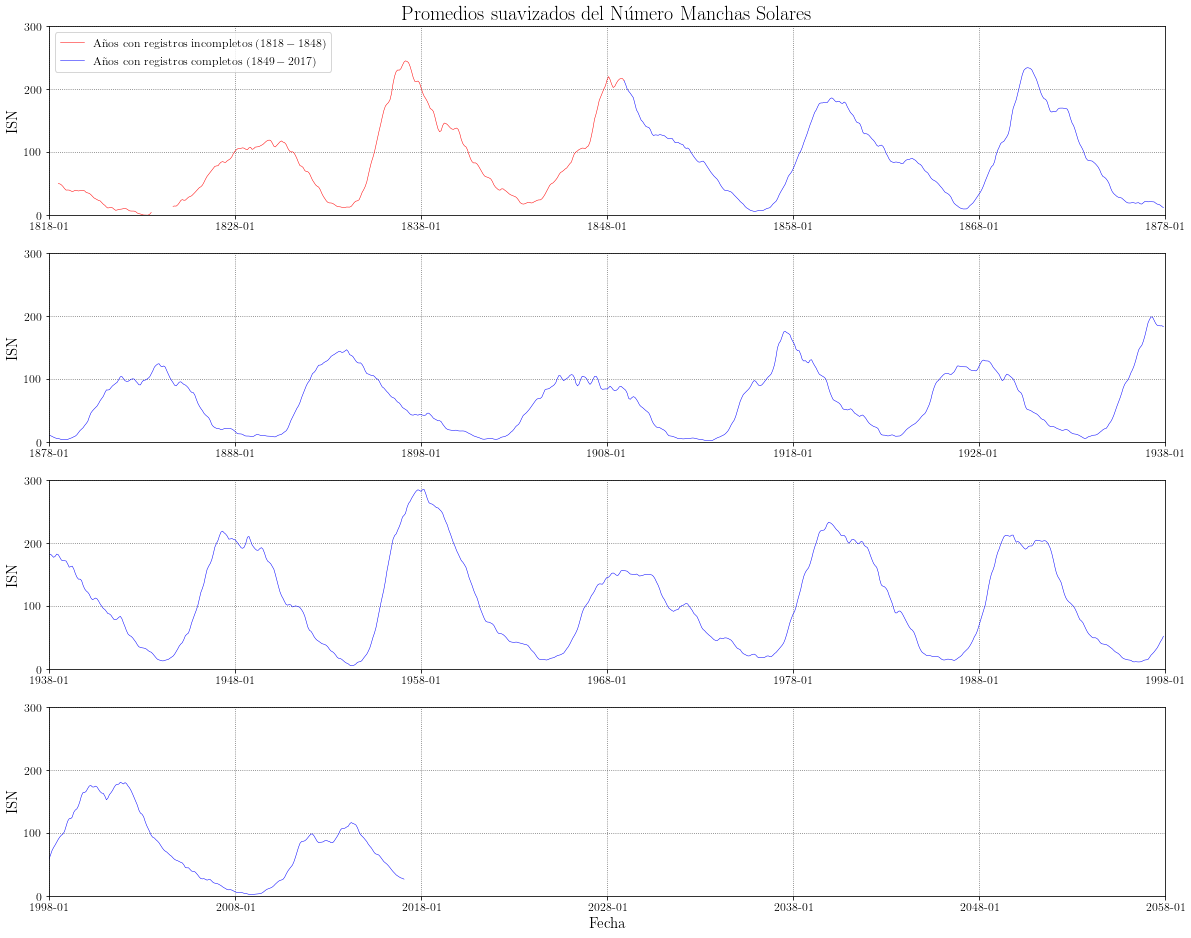

In [34]:
from pandas import Timedelta

yearDelta = 60
periods = (smooth.index[-1].year - smooth.index[0].year) / yearDelta
periods = ceil(periods)
periods = int(periods)

fig = figure(figsize=(20, periods * 4), frameon=False)

title = r"$\mathrm{Promedios\ suavizados\ del\ N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = ceil(nanmax(smooth['Smooth SN mean']) / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot('{0:.0f}1{1:.0f}'.format(periods, i + 1))

    x_liml = Timestamp(smooth.index[0].year + i * yearDelta, 1, 1)
    x_limu = Timestamp(smooth.index[0].year + (i + 1) * yearDelta - 1, 12, 31)

    plotData = smooth[x_liml:x_limu]

    if i == 0:
        nanStop = 0
        nanStop = where(isnan(daily['SN value']))[0][-1] + 1
        nanStop = daily.index[nanStop]
        nanStop = plotData[:nanStop].index[-1]
        
        graph, = plot(
            plotData['Smooth SN mean'][:nanStop],
            color='red',
            linewidth=0.5,
            antialiased=True,
            label=(r"$\mathrm{A\tilde{n}os\ con\ }$" +
                   r"$\mathrm{registros\ incompletos\ }$" +
                   r"$({0:}-{1:})$".format(plotData.index[0].year,
                                           plotData[:nanStop].index[-1].year)))
        
        graph, = plot(
            plotData['Smooth SN mean'][nanStop:],
            color='blue',
            linewidth=0.5,
            antialiased=True,
            label=(
                r"$\mathrm{A\tilde{n}os\ con\ }$" +
                r"$\mathrm{registros\ completos\ }$" + r"$({0:}-{1:})$".format(
                    plotData[nanStop:].index[0].year+1,
                    daily.index[-1].year)))

        axs.set_title(title, fontproperties=font_title)
        axs.legend(loc=2, prop=font_legend)
    else:
        plot(
            plotData['Smooth SN mean'],
            color='blue',
            linewidth=0.5,
            antialiased=True)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(yearDelta / 10)
    d_xticks = ceil(
        (x_limu.year - (x_liml + Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [
        Timestamp(int(x_liml.year + i * d_xticks), 1, 1)
        for i in range(n_xticks + 1)
    ]
    l_xticks = [
        r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks
    ]

    axs.set_xlim([x_liml, x_limu + Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    axs.grid(color='#666666', linestyle='dotted')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)

show()

##### Superposición de promedios sauvizados sobre los mensuales

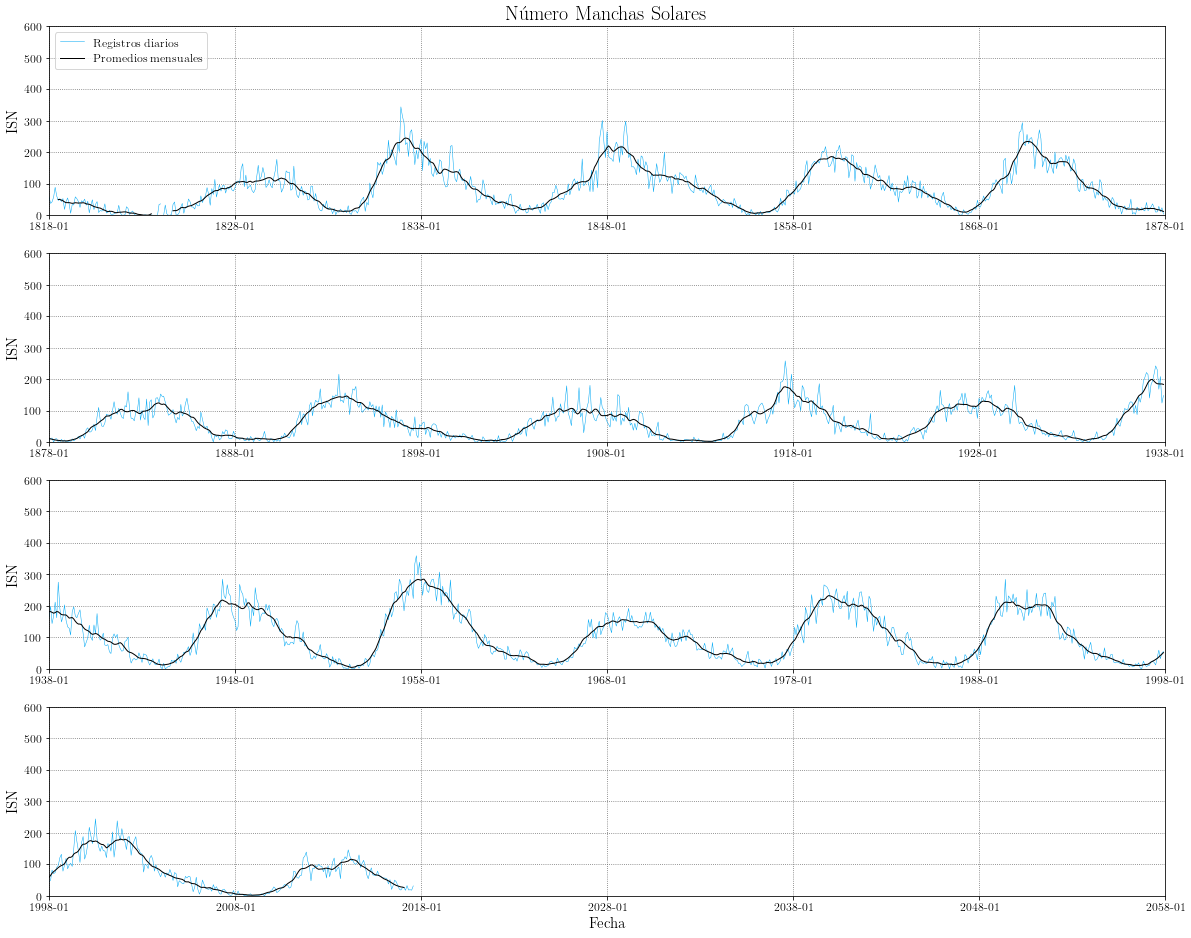

In [35]:
from pandas import Timedelta

yearDelta = 60
periods = (monthly.index[-1].year - monthly.index[0].year) / yearDelta
periods = ceil(periods)
periods = int(periods)

fig = figure(figsize=(20, periods * 4), frameon=False)

title = r"$\mathrm{N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = ceil(nanmax(daily['SN value']) / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot('{0:.0f}1{1:.0f}'.format(periods, i + 1))

    x_liml = Timestamp(daily.index[0].year + i * yearDelta, 1, 1)
    x_limu = Timestamp(daily.index[0].year + (i + 1) * yearDelta - 1, 12, 31)

    plotData = monthly[x_liml:x_limu]

    graph, = plot(
        plotData['Monthly SN mean'],
        color='#03a9f4',
        linewidth=0.5,
        antialiased=True,
        label=(r"$\mathrm{Registros\ diarios}$"))

    plotData = smooth[x_liml:x_limu]

    graph, = plot(
        plotData['Smooth SN mean'],
        color='black',
        linewidth=1.0,
        antialiased=True,
        label=(r"$\mathrm{Promedios\ mensuales}$"))

    if i == 0:
        axs.set_title(title, fontproperties=font_title)
        axs.legend(loc=2, prop=font_legend)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(yearDelta / 10)
    d_xticks = ceil((x_limu.year - (x_liml + Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [Timestamp(int(x_liml.year + i * d_xticks), 1, 1)  for i in range(n_xticks + 1)]
    l_xticks = [
        r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks
    ]

    axs.set_xlim([x_liml, x_limu + Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    axs.grid(color='#666666', linestyle='dotted')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)

show()